# Analysis of density waves based on $|\nabla\rho|$

In [1]:
from os import makedirs
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from utils import normalize_frequency, spatio_temporal_correlation
from flow_conditions import CHORD, A_INF, U_INF

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

data = "./output/naca0012_data/"
output = "./output/naca0012_analysis/slice/"
makedirs(output, exist_ok=True)

In [2]:
times = pt.load(f"{data}slice/times_ref1_z25.pt")
x = pt.load(f"{data}slice/x_ref1_z25.pt") / CHORD
y = pt.load(f"{data}slice/y_ref1_z25.pt") / CHORD
magGradRho = pt.load(f"{data}slice/magGradRho_ref1_z25.pt")
n_points = x.shape[0]
n_times = times.shape[0]

In [3]:
np_line = 21
line = pt.stack((
    pt.linspace(0.7, 0.8, np_line),
    pt.linspace(0.5, 0.5, np_line),
)).T

In [4]:
mgr = []
vertices = pt.stack((x, y), dim=1)
for pi in range(line.shape[0]):
    closest = (vertices - line[pi]).norm(dim=1).argmin()
    mgr.append(magGradRho[closest])
mgr = pt.stack(mgr, dim=1).T

In [5]:
dx_i = line[1, 0] - line[0, 0]
dt_i = times[1] - times[0]
dx = line[-1, 0] - line[0, 0]
dt = times[-1] - times[0]

In [6]:
n_tau = 50
tau = pt.arange(-n_tau*dt_i, (n_tau+0.1)*dt_i, dt_i) * U_INF / CHORD
dd, tt = pt.meshgrid(line[:, 0], tau)

In [7]:
R_test = spatio_temporal_correlation(mgr, n_tau)

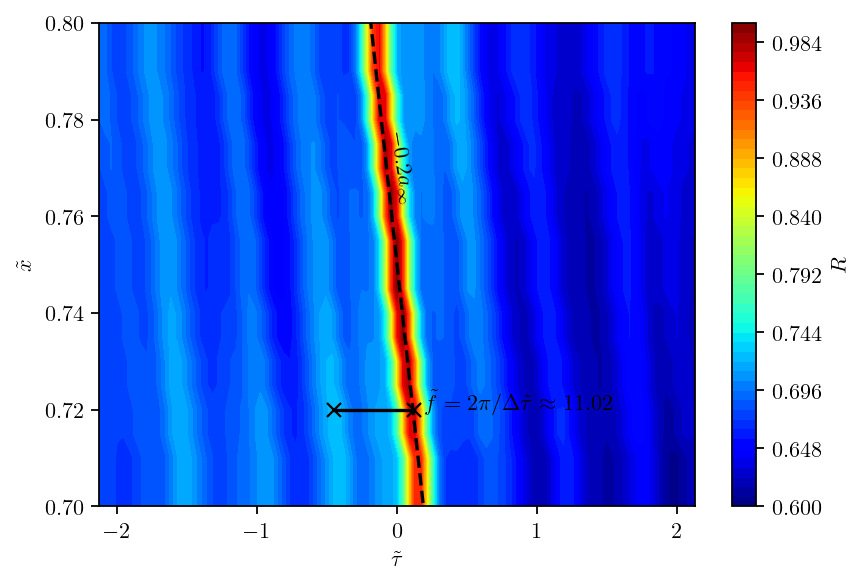

In [8]:
cf = plt.contourf(tt, dd, R_test, levels=50, cmap="jet")
plt.colorbar(cf, label=r"$R$")
slope = -0.2*A_INF / U_INF
plt.plot(tau, tau*slope+0.75, ls="--", c="k")
plt.text(-0.075, 0.77, r"$-0.2a_\infty$", rotation=-81, va="center")
plt.plot([0.12, -0.45], [0.72, 0.72], c="k", marker="x")
plt.text(0.2, 0.72, r"$\tilde{{f}} = 2\pi/\Delta \tilde{{\tau}} \approx {:2.2f}$".format(1.0/(0.45 + 0.12)*2.0*np.pi))
plt.ylim(0.7, 0.8)
plt.ylabel(r"$\tilde{x}$")
plt.xlabel(r"$\tilde{\tau}$")
plt.show()

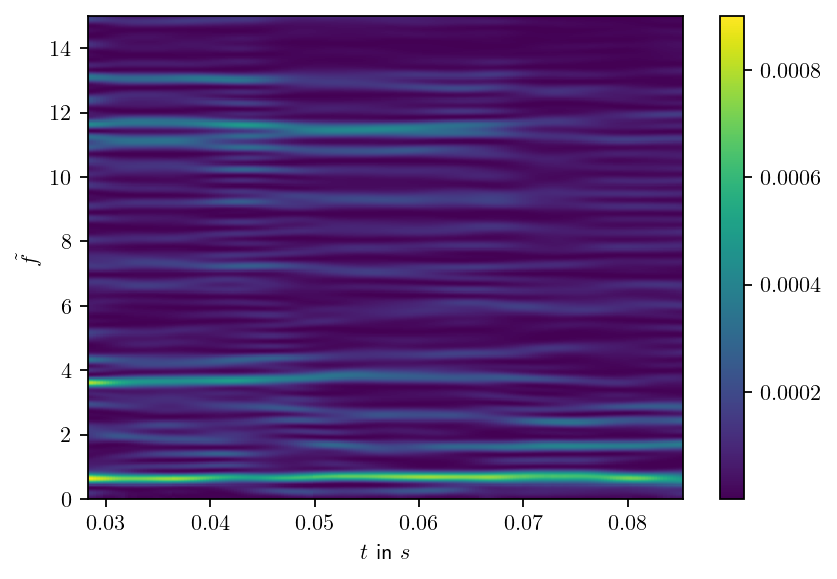

In [9]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(mgr[10].numpy(), 1.0/dt_i.item(), nperseg=int(times.shape[0]/2), noverlap=int(times.shape[0]/2.01), nfft=times.shape[0]*4)

#pcol = plt.pcolormesh(t, normalize_frequency(f), np.log(np.where(Sxx > 0.01, Sxx, 0.01)), shading='auto')
pcol = plt.pcolormesh(t, normalize_frequency(f), Sxx, shading='auto')
plt.colorbar(pcol)
plt.ylabel(r"$\tilde{f}$")
plt.xlabel(r"$t$ in $s$")
plt.ylim(0, 15)
plt.show()